# Sink or survive - data exploration in the Titanic challenge

## 1. Introdution

As an aspiring data scientist, this notebook is my first attempt at performing and presenting a thorough analysis of a dataset on Kaggle.com: **Titanic - machine learning from disaster**. Based on a list of passengers with several attributes (name, sex, class, cabin, etc.), we have to predict who will survive the catastrophe. In order to do this, we shall look at the training data and scrutinise the different predictors one by one, engineering new features if neccessary for a better model. For the feature engineering - especially being a novice in machine learning - the forums on Kaggle have inspired me with quite a few ideas. Subsequently, we will construct a model for prediction by training a forest of decision trees on the features of the training data. This done, we will now apply this model to the test data (that does **not** contain the information about survival) and predict who is expected to survive - and who will sink. As this is an ongoing project, I will continuously update the model with better-constructed features and parameters. 

Here is the list according to which we will proceed.

### 1.1. Imports
Importing the neccessary Python libraries.
### 1.2. Examining the features
Exploring the predictors of the dataset and engineering new ones.
### 1.3. Cleanup and preparation for analysis
Dropping unnecessary columns, modifying the form of classification so that it is better matched with model training.
### 1.4. Training the model
Creating the actual model. We will use a decision tree based classification method, **Random Forests**.
### 1.5. Prediction and predictor relevance
Applying the model to the test data and examining the importance of the features used for prediction.

## 2. Imports and raw data
First, we import the necessary libraries for handling the data, for numerical manipulation and for training the model. Also, for finding bits of text in a more extensive string, we import the library for regular expressions.

In [345]:
# data handling 
import pandas as pd
from pandas import Series, DataFrame

from operator import itemgetter

# numerical manipulation and visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
%matplotlib inline

from scipy import stats

# regular expressions
import re

# machine learning
from sklearn.ensemble import RandomForestClassifier

We read in the **test** and **train** data as Pandas DataFrames, and examine the data structure.

In [346]:
train_df = pd.read_csv('../../PycharmProjects/Kaggle_Titanic/csv_files/train.csv', header=0)
test_df = pd.read_csv('../../PycharmProjects/Kaggle_Titanic/csv_files/test.csv', header=0)

In [347]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


So, what do we have here? 

* **PassengerId** identifies the particular passenger - it will not be of much use for survival prediction
* **Survived** is a binary predictor (yes: 1, no: 0) of survival - obviously, we only find it in the train data
* **Pclass** signifies the ticket class with possible values 1, 2, and 3. This is already something worth to look at!
* **Name** might not seem too interesting at first sight, but let's see if we can extract any useful information later on
* **Sex** of the passengers is probably strongly correlated with survival
* **Age**, as sex, is self-explanatory
* **SibSp** is the number of siblings/spouses travelling with the person
* **Parch** is the number of parents/children travelling with the person under consideration
* **Ticket** is the serial number of the ticket
* **Fare** is the money payed for the ticket
* **Cabin** contains information about the location of the cabin, it can be a useful predictor for survival
* **Embarked** shows the place of embarkation: Cherbourg (France), Southampton and Queenstown (UK), marked by their initials.

Let us get some global information about our raw data. It is obvious that quite a few entries are far from complete. We will have to do some clever data imputation to prepare the set for *machine learning*.

In [348]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


In [349]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 27.8+ KB


## 3. Examining the features
After reading in the data, as well as getting a rough feeling for the contents, we can get down to a more detailed examination.

### 3.1. Is sex important?
Well, obviously it is, in several senses and situations - but how about this one? The proverbial *"Save the women and the children!"* prompts us to consider it as an important predictor for survival.

The graphs below indicate that there is a drastic difference of survival odds if you were a male or a female on the ship! For the almost twice as many women than men, the survival probability of woman passengers is about 4 times that of men.

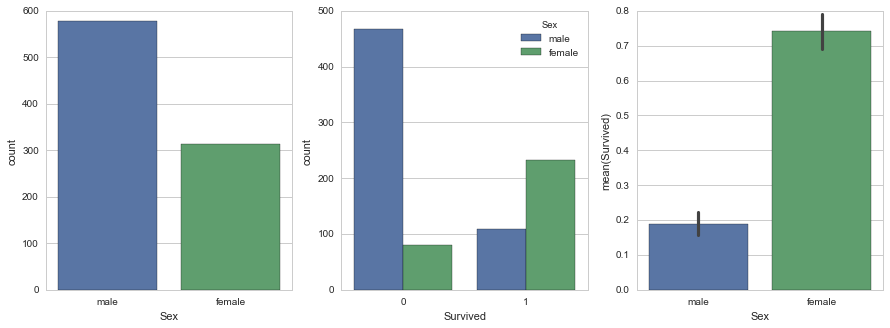

In [350]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(15, 5))

sns.countplot(x='Sex', data=train_df, ax=axis1)
sns.countplot(x='Survived', hue='Sex', data=train_df, ax=axis2)
sns.barplot(x='Sex', y='Survived', data=train_df, ax=axis3)

### 3.2. Titles and entitlement

On closer examination, we see that the **Name** column contains honorifics by each name. I would guess that probably those of the nobility have higher chances to survive. Let us see if it is the case. Extracting the titles has another importance: since there are quite a few age values missing, we will have to input them - however, if someone with a *Master* honorific (which was a common one for boys aged less than 16) gets an age of 50, or we have a *Mr* aged 2, we would be making a mistake.

First, let us define a function that finds these titles using regular expressions and use it to fill a **Title** column with them. 

In [351]:
def extract_title(name):  # function that returns a list of honorifics extracted from Names
    
    return re.findall(r',\s[\w\s]+.', name)[0][2:-1]

# Create and fill 
train_df['Title'] = train_df['Name'].map(extract_title)
test_df['Title'] = test_df['Name'].map(extract_title)

# See what kind of titles we have
print((set(train_df['Title'].values) | set(test_df['Title'].values)))

{'Mme', 'Jonkheer', 'Ms', 'Sir', 'Rev', 'the Countess', 'Mrs', 'Mr', 'Dona', 'Dr', 'Mlle', 'Miss', 'Lady', 'Master', 'Don', 'Col', 'Capt', 'Major'}


We have got quite a few different titles on our hands! Some of them are your everyday Mr, Mrs, etc, but there are also special ones indicating a scientific degree, military occupation or nobility.

There is another flavour to this: *ethnicity*! *Sir*, *Lady*, *Countess* suggest an anglo-saxon origin, *Mme* and *Mlle* are obviously French (possibly Belgian), *Jonkheer* could be Dutch (or Belgian) and *Don/Dona* suggest a Spanish/Portuguese/Italian origin. Was it easier to survive if you were English, or French, rather than of a  different nation?  In another version of this notebook, I will explore the relevance of ethnicity to see whether it can be a useful feature to predict survival - right now I just mark it as an interesting point.

For now, let us translate the equivalents to English (for example *Mlle* corresponds to *Ms*) and then bin the titles. For the latter, there are many possible choices, here I will just leave the common titles (*Master*, *Mr*, *Ms*, *Mrs*) as they are, take the military and scientific titles and bin them into *special*, whereas the noble ones go - unsurprisingly - into *noble*.

In [352]:
# Translating the equivalents:
train_df.loc[train_df['Title'] == 'Mlle', 'Title'] = 'Ms'
train_df.loc[train_df['Title'] == 'Miss', 'Title'] = 'Ms'
train_df.loc[train_df['Title'] == 'Mme', 'Title'] = 'Mrs'

test_df.loc[test_df['Title'] == 'Mlle', 'Title'] = 'Ms'
test_df.loc[test_df['Title'] == 'Miss', 'Title'] = 'Ms'
test_df.loc[test_df['Title'] == 'Mme', 'Title'] = 'Mrs'


# Grouping 
def assign_title(title):
    
    if title in ['Don', 'Dona', 'Lady', 'the Countess', 'Sir', 'Jonkheer']:
        return 'noble'
    elif title in ['Dr', 'Rev', 'Major', 'Col', 'Capt', 'Major']:
        return 'special'
    else:
        return title

train_df['Title'] = train_df['Title'].map(assign_title)
test_df['Title'] = train_df['Title'].map(assign_title)

Having extracted, translated and rearranged, let us now investigate the implications.

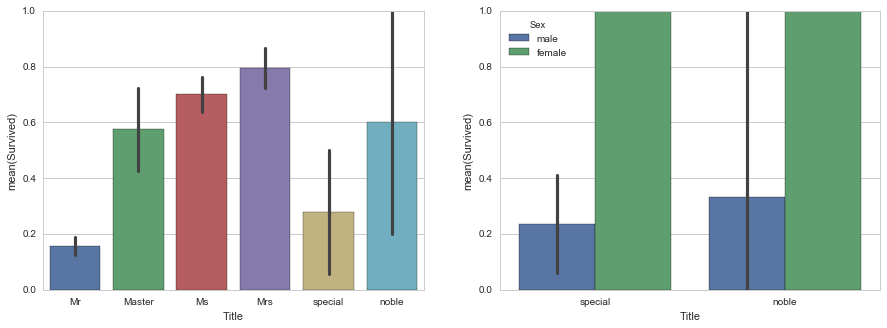

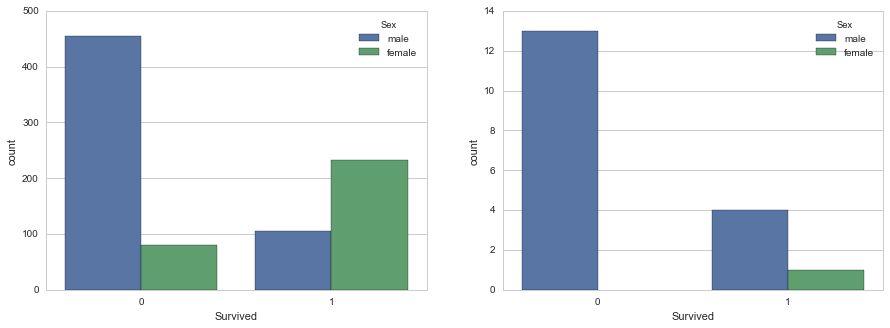

In [353]:
figure, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(x='Title', y='Survived', data=train_df, order = ['Mr', 'Master', 'Ms', 'Mrs', 'special', 'noble'], ax=axis1)
sns.barplot(x='Title', y='Survived', data=train_df, hue='Sex', order = ['special', 'noble'], ax=axis2)


nobles = train_df[train_df['Title'] == 'special']
non_nobles = train_df[train_df['Title'] != 'special']

figure, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(x='Survived', data=non_nobles, hue='Sex', ax=axis1)
sns.countplot(x='Survived', data=nobles, hue='Sex', ax=axis2)


Apparently, if you were a member of the nobility, you were in luck! Well, at least, your chances of survival were considerably higher than those of common mortals. Especially noblewomen - they really hit the jackpot on this one. We need to mention, however, that there were only 6 of them altogether, from whom 4 survived, i.e., nobility were less than 1% of the total number of passangers!  According to the graphs, *Mr* have by far the lowest chance of survival, young boys of age <16 survive on average. The survival rate of women is even higher, while **special** doesn't seem to indicate anything special. All in all, **Title** is apparently a valuable feature for predicting survival!

### 3.3. Does Age matter?

It is reasonable to guess that age is going to factor into survival chances. Children, especially young ones, were surely helped to the lifeboats, whereas if you were old, the probability that you were left behind, or injured in the turbulent crowd, was much greater. These are of course speculations, so let the numbers speak!

Unfortunately, some of the age values are missing, so we will have to assume them. There are several possible ways to do this: for example, one could randomly pick a value between the extrema of the age span of the passangers, or, better still, take the *mean* and the *standard deviation* of the age distribution, and randomly choose values from an interval of 2\*std_dev centered around the mean. The way we will proceed is a bit more sophisticated. We will construct a probability kernel distribution estimate from the distribution of the existing values, and get the missing age values according to it.

As an additional constraint, we add that the assigned age value should not clash with the honorific of the person, i.e., we don't want to  have a 5 year old *Mrs* or a *Master* who is close to retirement.

In [354]:
# Filling in the missing age values with ones chosen according to a given probability distribution
def assign_age(df, age_range, probabilities):
    
    null_age_count = df['New_Age'].isnull().sum()  # number of null age values
    random_ages = np.random.choice(age_range, size=null_age_count, p=probabilities)  # generate this number of age values
                                                                                    # with the given probability distribution
    df.loc[df['New_Age'].isnull(), 'New_Age'] = random_ages  # assign the ages to the null value entries
    
    # Check that the ages do not clash with the honorifics
    # Filters:
    is_master = df['Title'] == 'Master'
    not_master = df['Title'] != 'Master'
    not_miss = df['Title'] != 'Ms'
    is_younger = df['New_Age'] <= 16
    is_older = df['New_Age'] > 16
    
    # If there is a clash, set those age values (and only those) that clash with the honorifics to zero
    df.loc[is_master & is_older, 'New_Age'] = None
    df.loc[not_master & not_miss & is_younger, 'New_Age'] = None
    null_age_count = df['New_Age'].isnull().sum()
    
    return null_age_count  # how many New_Age entries are still null


# Estimating the kernel density for the non-null age values
train_kde = stats.gaussian_kde(train_df['Age'].dropna())
train_age_min = train_df['Age'].dropna().min().astype(int)
train_age_max = train_df['Age'].dropna().max().astype(int)

test_kde = stats.gaussian_kde(test_df['Age'].dropna())
test_age_min = test_df['Age'].dropna().min().astype(int)
test_age_max = test_df['Age'].dropna().max().astype(int)


# then build the age values to choose from and their probability distribution
train_age_points = np.array(range(train_age_min, train_age_max+1))
train_kde_points = train_kde(np.array(train_age_points))

test_age_points = np.array(range(test_age_min, test_age_max+1))
test_kde_points = test_kde(np.array(test_age_points))


# We normalise the kde to get a probability sum of 1 (discretising the continuous probability function)
train_kde_normalised = train_kde_points / (train_kde_points.sum())
test_kde_normalised = test_kde_points / (test_kde_points.sum())


null_count = train_df['Age'].isnull().sum()  # number of null age values
train_df['New_Age'] = train_df['Age']

# Now, we reassign age values according to the kde, until there are none which clash with the honorifics
while null_count:
    null_count = assign_age(train_df, train_age_points, train_kde_normalised)
    
# Doing the same for the test data
null_count = test_df['Age'].isnull().sum()  # number of null age values
test_df['New_Age'] = test_df['Age']
while null_count:
    null_count = assign_age(test_df, test_age_points, test_kde_normalised)

Now that we have filled in the missing values, let us look at the new distribution of age values.

C:\Users\David Dzsotjan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


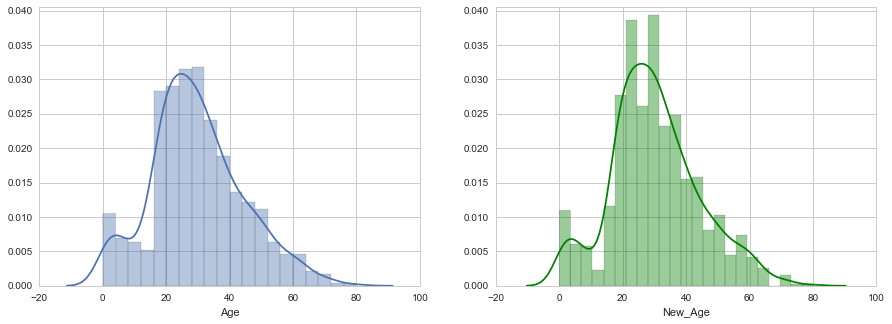

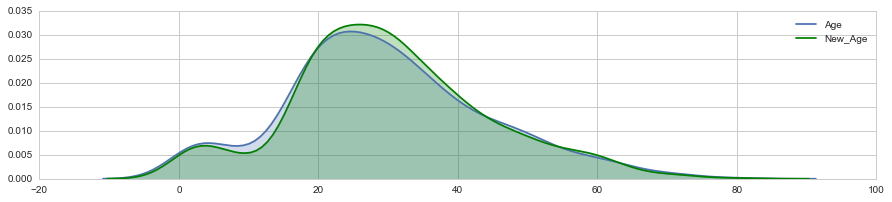

In [355]:
figure, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 5))

fig1 = sns.distplot(train_df['Age'].dropna().astype(int), ax=axis1)
fig2 = sns.distplot(train_df['New_Age'].dropna().astype(int), color='g', ax=axis2)

fig1.set(ylim = (0, 1.3 * max(train_kde_normalised)))
fig2.set(ylim = (0, 1.3 * max(train_kde_normalised)))

# Putting the kde for both distributions in the same plot

figure, axis1 = plt.subplots(1, 1, figsize=(15, 3))

sns.kdeplot(train_df['Age'].dropna(), ax=axis1, shade=True)
sns.kdeplot(train_df['New_Age'], ax=axis1, color='g', shade=True)

# We see that the distribution is practically the same as before the imputation, and we also respected the prefixes!

# Age distribution seems fine, we give the new values to 'Age' and drop 'New_Age'
train_df['Age'] = train_df['New_Age'].astype(int)
test_df['Age'] = test_df['New_Age'].astype(int)

train_df.drop('New_Age', axis=1, inplace=True)
test_df.drop('New_Age', axis=1, inplace=True)


Apparently, we have done quite a good job: the new age distribution corresponds quite well to the original. This seems to be something we can work with. Let's get a feeling for the survival rate as a function of age.

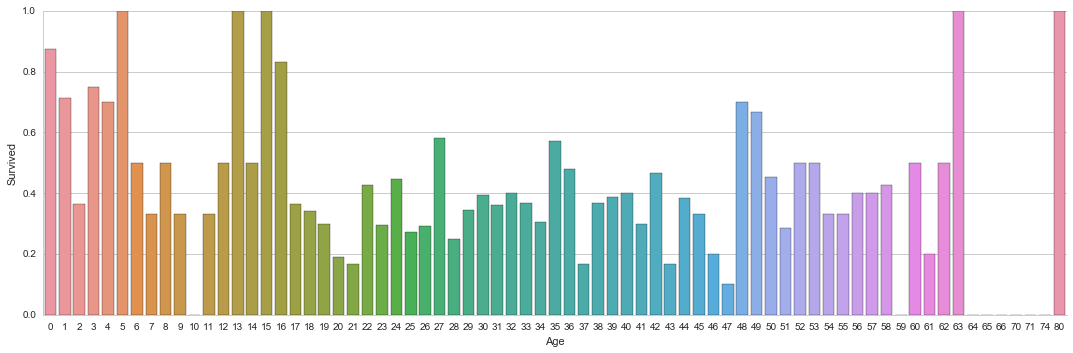

In [356]:
# Look at survival rates as a function of age
average_survival = train_df[['Age', 'Survived']].groupby(['Age'], as_index=False).mean()

# Plotting the survival rates
sns.factorplot(x='Age', y ='Survived', kind='bar', data=average_survival, size=5, aspect=3)

We see that survival rates below the age 16 are quite high. It would be advantageous to create bins for the age values to get a better grip on the conection between age and survival - so let's get to it!

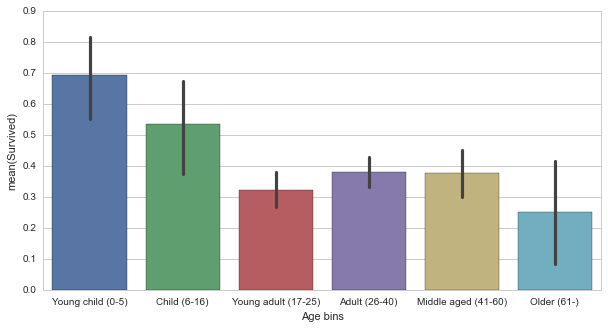

In [357]:
# Binning the ages: we use the .cut() method of pandas
train_df['Age bins'] = train_df['Age']
test_df['Age bins'] = test_df['Age']

age_bins = [-0.1, 5, 16, 25, 40, 60, 100]
age_labels = ['Young child (0-5)', 'Child (6-16)', 'Young adult (17-25)', 'Adult (26-40)', 'Middle aged (41-60)', 'Older (61-)']
train_df['Age bins'] = pd.cut(train_df['Age'], age_bins, labels=age_labels)
test_df['Age bins'] = pd.cut(test_df['Age'], age_bins, labels=age_labels)

figure, axis1 = plt.subplots(1, figsize = (10, 5))
sns.barplot(x='Age bins', y='Survived', data=train_df)

The barplots show that indeed below 16 years old, survival rates are above 0.5 on average, whereas for the older passangers the average chance to survive is well below 50%.

### 3.4. The power of Family

Travelling all alone, or with a family where members look out for each other could make all the difference between survival or sinking to the bottom. Family size can be easily constructed adding predictors **Parch** and **SibSp**.

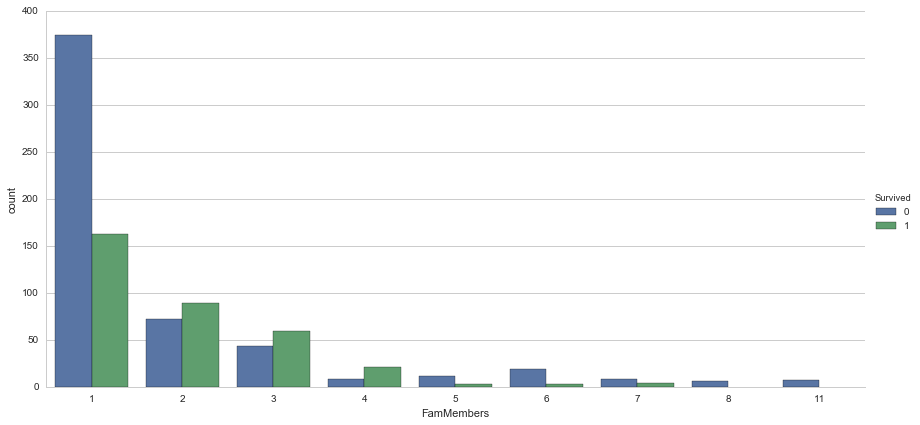

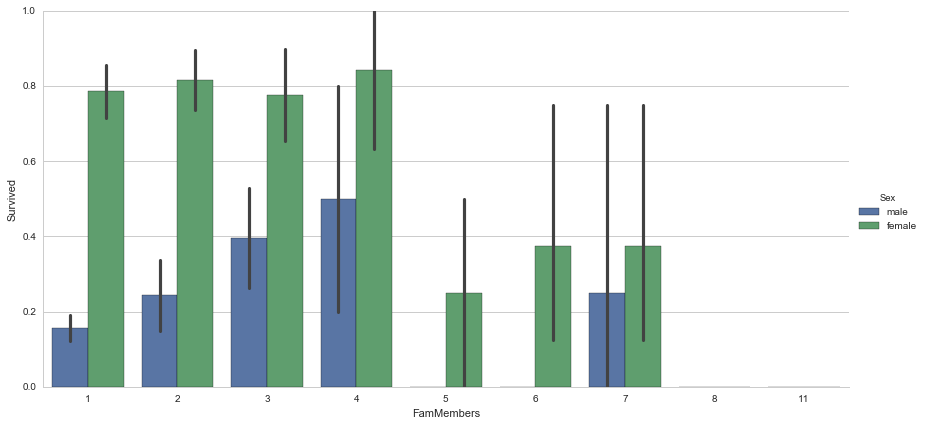

In [358]:
train_df['FamMembers'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamMembers'] = test_df['SibSp'] + test_df['Parch'] + 1

sns.factorplot(x='FamMembers', data=train_df, kind='count', hue='Survived', size=6, aspect=2)
sns.factorplot(x='FamMembers', y='Survived', data=train_df, kind='bar', hue='Sex', size=6, aspect=2)

We see an interesting trend here: survival rate is larger than 0.5 by families ranging from 2 to 4 members. Singletons as well as people in larger families have a lower chance of survival. Also, we see that while ladies have about the same survival rate until a family size of 4 (including all the single ladies), the odds to live for males increases with family size - just until families of 4.

From this, it seems a sensible choice to categorise peoples' family size as **single**, **small** (the sweet spot between 2 and 4 members) and **large**.

In [359]:
train_df.loc[train_df['FamMembers'] > 4, 'FamSize'] = 'large (>4 members)'
train_df.loc[(train_df['FamMembers'] >= 2) & (train_df['FamMembers'] <= 4), 'FamSize'] = 'small (2-4 members)'
train_df.loc[train_df['FamMembers'] == 1, 'FamSize'] = 'single'

test_df.loc[test_df['FamMembers'] > 4, 'FamSize'] = 'large (>4 members)'
test_df.loc[(test_df['FamMembers'] >= 2) & (test_df['FamMembers'] <= 4), 'FamSize'] = 'small (2-4 members)'
test_df.loc[test_df['FamMembers'] == 1, 'FamSize'] = 'single'

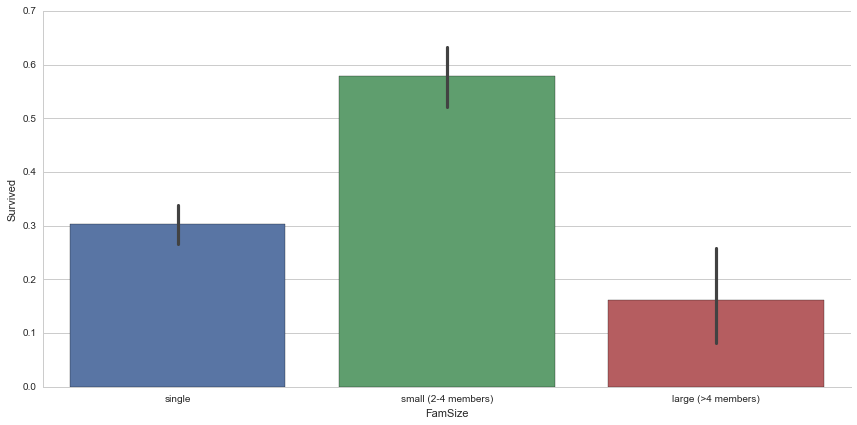

In [360]:
sns.factorplot(x='FamSize', y='Survived', data=train_df, kind='bar', order = ['single', 'small (2-4 members)', 'large (>4 members)'], size = 6, aspect =2)

We see indeed that the small families (very possibly due to an optimal combination of cooperation and mobility) have a way larger rate of survival than single people or members of larger families!

### 3.5. Classy enough?

The higher the ticket class, the higher the comfort - but what about the survival probability? Certainly, spaces occupied by 1st class passengers must have been wider and much less encumbered by people and objects than, say, in the 3rd class regions of the ship, which is an advantage in case of an evacuation. Also, 1st class cabins were on the deck closest to the lifeboats, so this seems to bode well for the upper crust.

The **Pclass** column has all its values so we can go straight to the graphs and see the implications of poshness on survival.

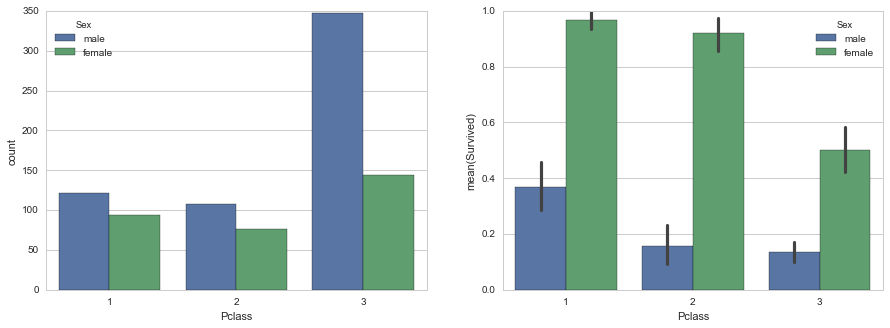

In [361]:
figure, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x='Pclass', data=train_df, hue='Sex', ax=axis1)
sns.barplot(x='Pclass', y='Survived', data=train_df, hue='Sex', ax=axis2)

And indeed, the chances of survival drop as ticket class increases. The probability to be rescued is lowest for 3rd-class passengers (which were, sadly, also the most numerous and were mostly left to fend for themselves in the wake of the disaster). It is interesting to note that for women, there is a larger jump in survival odds from 3rd to 2nd class, whereas for men it is from 2nd to 1st class. Nonetheless, it is true for both sexes that their prospects improve with the swankiness of their accomodations on the ship.

### 3.6. Putting a price on survival

We have seen that passenger class has an effect on passenger survival. The prices paid for the tickets must certainly be correlated with the class which implies a connection with survival odds. Let's explore this a little bit more!

First, however, we must input a single missing price value in the *test data*. For this, we simply take the median for the given class.

In [362]:
no_fare = test_df['Fare'].isnull()
no_fare_class = test_df[no_fare]['Pclass'].values[0]

test_df.loc[no_fare, 'Fare'] = test_df[test_df['Pclass'] == no_fare_class]['Fare'].dropna().median()

One more thing might be a bit of a puzzle at first sight: some of the adult passengers apparently paid nothing to get on board! However, with a bit of research on the internet they turn out to be employees on the ship, or connected in some way or another to the owners/operators of the vessel (by some of them it is obvious: the *LINE* entry for **Ticket** is a tell-tale sign, meaning that they were *American Line* employees).

In [363]:
train_df[train_df['Fare']<3].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age bins,FamMembers,FamSize
179,180,0,3,"Leonard, Mr. Lionel",male,36,0,0,LINE,0.0,NaN,S,Mr,Adult (26-40),1,single
263,264,0,1,"Harrison, Mr. William",male,40,0,0,112059,0.0,B94,S,Mr,Adult (26-40),1,single
271,272,1,3,"Tornquist, Mr. William Henry",male,25,0,0,LINE,0.0,NaN,S,Mr,Young adult (17-25),1,single
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,41,0,0,239853,0.0,NaN,S,Mr,Middle aged (41-60),1,single
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19,0,0,LINE,0.0,NaN,S,Mr,Young adult (17-25),1,single


Having got confusion out of the way, let us look at the distribution of prices in each class.

C:\Users\David Dzsotjan\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
C:\Users\David Dzsotjan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
C:\Users\David Dzsotjan\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\David Dzsotjan\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


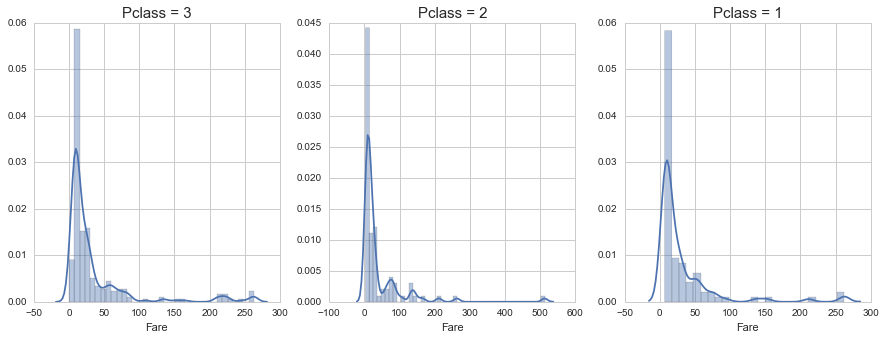

In [364]:
figure, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(15,5))
sns.distplot(test_df[train_df['Pclass'] == 3]['Fare'], ax=axis1)
sns.distplot(test_df[train_df['Pclass'] == 2]['Fare'], ax=axis2)
sns.distplot(test_df[train_df['Pclass'] == 1]['Fare'], ax=axis3)

axis1.set_title('Pclass = 3', fontsize=15)
axis2.set_title('Pclass = 2', fontsize=15)
axis3.set_title('Pclass = 1', fontsize=15)

Well, this comes as a bit of a surprise! It seems that prices are quite varied in each class and they encompass a wide spectrum so the correlation between price and class is not so obvious here. It could be a good idea however to plot the average fare for those who survived and those who didn't, sorted by class.

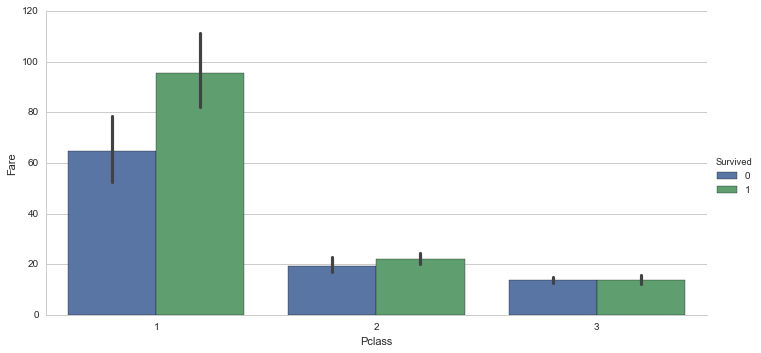

In [365]:
sns.factorplot(x='Pclass', y='Fare', data=train_df, hue='Survived', kind='bar', size=5, aspect=2)

# there is a significant difference for the average fare in case of the 1st class

This is a bit more helpful: in case of 1st class passengers there definitely is a significant difference between the average fare paid by the passengers who survived and those who did not. 

For the moment, let us bin the fare values into three categories: *cheap*, *middle* and *expensive*.

In [366]:
train_df['Fare bins'] = train_df['Fare']
test_df['Fare bins'] = test_df['Fare']
fare_labels = ['Cheap', 'Middle', 'Expensive']

train_df['Fare bins'] = pd.qcut(train_df['Fare bins'], 3, labels=fare_labels)
test_df['Fare bins'] = pd.qcut(test_df['Fare bins'], 3, labels=fare_labels)
                                

Let us look at the survival probabilities for the different price categories, filtered by class. We see that the supposed rule "the more expensive the ticket, the larger the chances of survival" hold for the 1st and 2nd class, but not for the 3rd! There, the survival rate is largest in the middle-range!

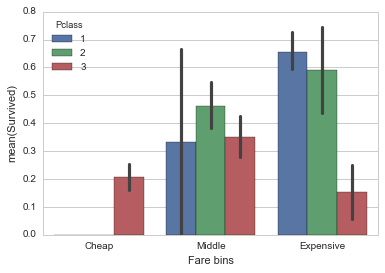

In [367]:
sns.barplot(x='Fare bins', y='Survived', hue='Pclass', data=train_df)

### 3.6.1. Feature: Fare per person

The fact that ticket prices vary so much inside a given class might be better understood if we look at **Fare** in the light of class **AND** family size.

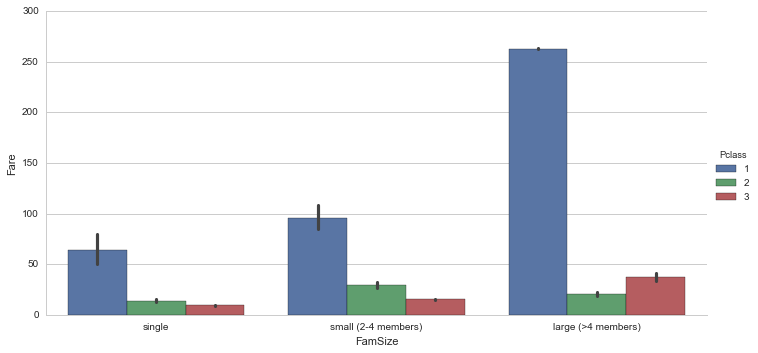

In [368]:
sns.factorplot(x='FamSize', y='Fare', data=train_df, hue='Pclass', kind='bar', 
               order=['single', 'small (2-4 members)', 'large (>4 members)'], size=5, aspect=2)

Well, this is intriguing! It seems that the average fares for different family sizes differ, with a relatively small standard deviation! We are definitely on to something here. Let us go even further and make the same plot, but this time as the function of the precise number of family members.

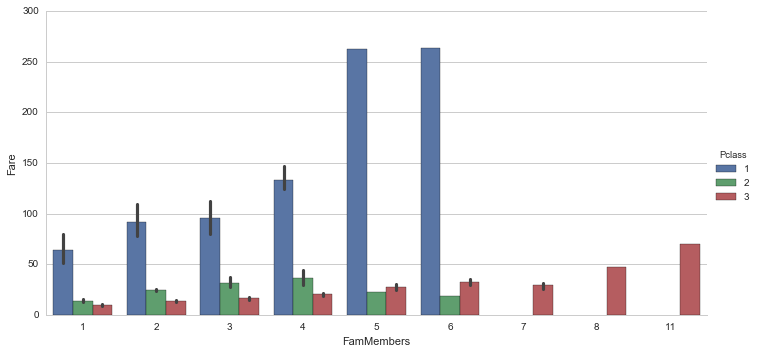

In [369]:
sns.factorplot(x='FamMembers', y='Fare', data=train_df, hue='Pclass', kind='bar', size=5, aspect=2)

Apparently, in each class, the average fare price varies with the size of the family. Also, we can see an almost steady increase in the price as the family size increases (except for the 2nd class, for 5 and 6 people). The standard deviations are relatively small (especially for the lower classes), so we can infer from this that **Family size** plays an important role in the variations in price! So instead of really associating the **Fare** with only a single person, we should rather think about it as **the price of the space occupied by the people travelling together**.

From this, it seems a good idea to construct a feature **Fare per person**. Let us look at the implications.

C:\Users\David Dzsotjan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


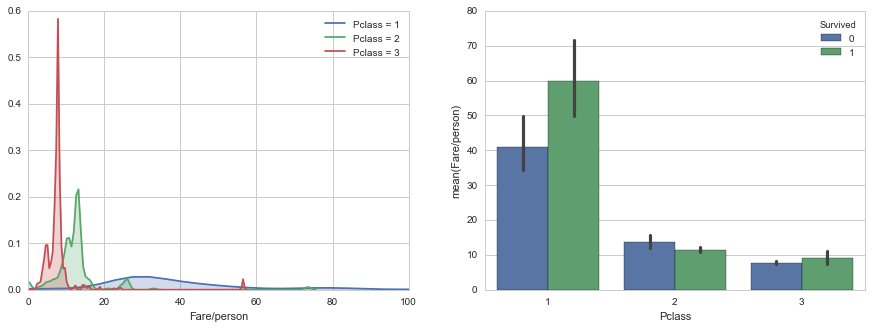

In [370]:
train_df['Fare/person'] = train_df['Fare']/train_df['FamMembers']
test_df['Fare/person'] = test_df['Fare']/test_df['FamMembers']

figure, (axis1, axis2) = plt.subplots(1, 2, figsize = (15,5))

fig1 = sns.kdeplot(train_df[train_df['Pclass'] == 1]['Fare/person'], shade=True, ax=axis1, label= 'Pclass = 1')
fig2 = sns.kdeplot(train_df[train_df['Pclass'] == 2]['Fare/person'], shade=True, ax=axis1, label= 'Pclass = 2')
fig3 = sns.kdeplot(train_df[train_df['Pclass'] == 3]['Fare/person'], shade=True, ax=axis1, label= 'Pclass = 3')

fig1.set(xlim = (0, 100))
fig1.set_xlabel('Fare/person')
fig2.set(xlim = (0, 100))
fig3.set(xlim = (0, 100))

sns.barplot(x='Pclass', y='Fare/person', data=train_df, hue='Survived', ax=axis2)

The **Fare/person** feature yields a much better separation in the distribution peaks of the different classes! Also, for the average fare of those who did and did not survive, we have a slightly better separation comcpared to **Fare**! This seems to be a potentially useful feature to help predicting survival in the test data. 

As with **Fare**, we put the values into bins, and look at the survival odds for the different classes.

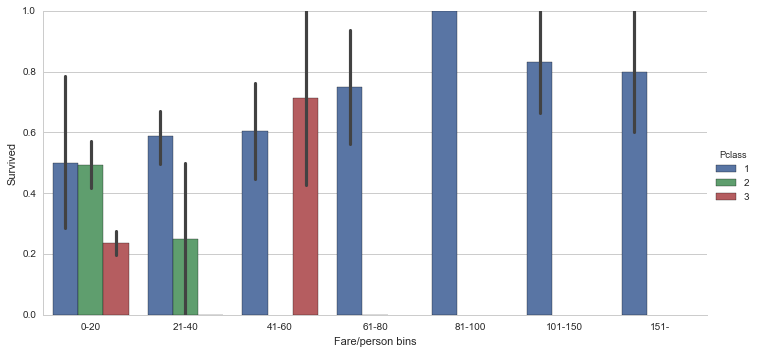

In [371]:
train_df['Fare/person bins'] = train_df['Fare/person']
test_df['Fare/person bins'] = test_df['Fare/person']

fpp_bins = [-0.1, 20, 40, 60, 80, 100, 150, 600]
fpp_labels = ['0-20', '21-40', '41-60', '61-80', '81-100', '101-150', '151-']
train_df['Fare/person bins'] = pd.cut(train_df['Fare/person'], fpp_bins, labels=fpp_labels)
test_df['Fare/person bins'] = pd.cut(test_df['Fare/person'], fpp_bins, labels=fpp_labels)

sns.factorplot(x='Fare/person bins', y='Survived', hue='Pclass', data=train_df, kind='bar', size=5, aspect=2)

In [372]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
PassengerId         891 non-null int64
Survived            891 non-null int64
Pclass              891 non-null int64
Name                891 non-null object
Sex                 891 non-null object
Age                 891 non-null int32
SibSp               891 non-null int64
Parch               891 non-null int64
Ticket              891 non-null object
Fare                891 non-null float64
Cabin               204 non-null object
Embarked            889 non-null object
Title               891 non-null object
Age bins            891 non-null category
FamMembers          891 non-null int64
FamSize             891 non-null object
Fare bins           891 non-null category
Fare/person         891 non-null float64
Fare/person bins    891 non-null category
dtypes: category(3), float64(2), int32(1), int64(6), object(7)
memory usage: 86.2+ KB


### 3.7. Where you Embarked - and where you arrive...

The **Embarked** column has 3 possible values, *S, C* and *Q*, that is, the embarkation happened either at Southampton (UK), Cherbourg (France) or Queenstown (UK). Let's have a look whether the point of embarkation made any difference between sink and swim in the wake of the calamity.

First, we have to do some value imputation, since the value is missing by two passengers. It is a possibility to choose a random city, but we have another handle: **Fare**. Both of these single ladies travelled 1st class and bought their tickets for 80 $.

In [373]:
train_df[train_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age bins,FamMembers,FamSize,Fare bins,Fare/person,Fare/person bins
61,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80.0,B28,NaN,Ms,Adult (26-40),1,single,Expensive,80.0,61-80
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80.0,B28,NaN,Mrs,Older (61-),1,single,Expensive,80.0,61-80


We can examine the **Fare** distribution of 1st class passengers who embarked from the different cities, and look for the median values - and use it as a point of comparison with the price paid by these two passengers.

C:\Users\David Dzsotjan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


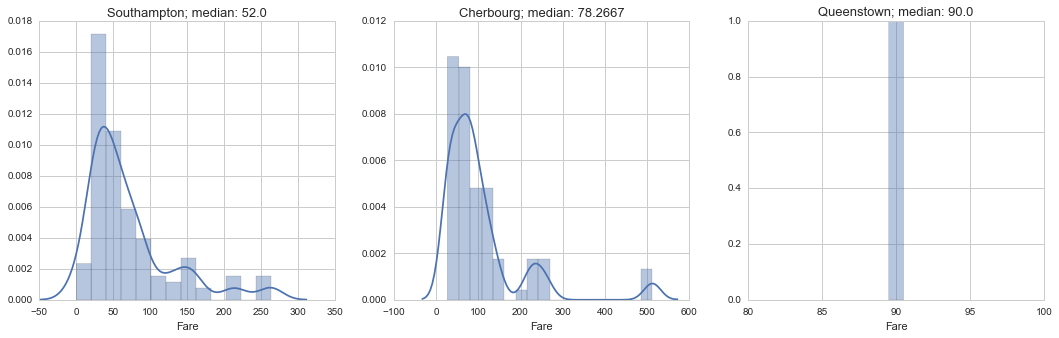

In [374]:
median_S = train_df[(train_df['Embarked'] == 'S') &(train_df['Pclass'] == 1)]['Fare'].median()
median_C = train_df[(train_df['Embarked'] == 'C') &(train_df['Pclass'] == 1)]['Fare'].median()
median_Q = train_df[(train_df['Embarked'] == 'Q') &(train_df['Pclass'] == 1)]['Fare'].median()

figure, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(18, 5))
sns.distplot(train_df[(train_df['Embarked'] == 'S') & (train_df['Pclass'] == 1)]['Fare'], ax=axis1)
sns.distplot(train_df[(train_df['Embarked'] == 'C') & (train_df['Pclass'] == 1)]['Fare'], ax=axis2)
fig=sns.distplot(train_df[(train_df['Embarked'] == 'Q') & (train_df['Pclass'] == 1)]['Fare'], ax=axis3)
fig.set(xlim=(80, 100))

axis1.set_title('Southampton; median: ' + str(median_S), fontsize = 13)
axis2.set_title('Cherbourg; median: ' + str(median_C), fontsize = 13)
axis3.set_title('Queenstown; median: ' + str(median_Q), fontsize = 13)

Based on the above, we choose their **Embarked** value to be *C*, since their fare is closest to the median of that particular distribution, also like the two ladies, most 1st class passengers who got on the ship in Cherbourg got their cabins on deck B (as seen in the **Cabin** column).

In [375]:
train_df.loc[train_df['Embarked'].isnull(), 'Embarked'] = 'C'

Having a full list of values, let's visualise survival odds according to where the passengers embarked.

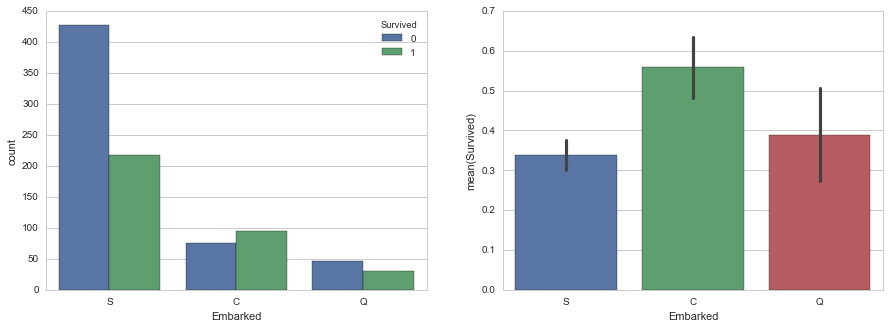

In [376]:
figure, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(x='Embarked', hue='Survived', data=train_df, ax=axis1)
sns.barplot(x='Embarked', y='Survived', data=train_df, ax=axis2)

Apparently, those who waited for the ship in Cherbourg had much higher odds to survive then the others.

### 3.8.  Feature: Age * Pclass

As we see a correlation in both the age bins and passenger class with survival odds, it can be a good idea to engineer a new parameter by multiplying them and binning the result.

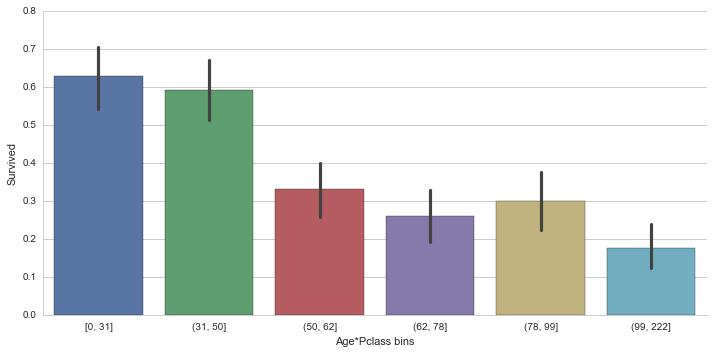

In [377]:
train_df['Age*Pclass'] = train_df['Age'] * train_df['Pclass']
test_df['Age*Pclass'] = test_df['Age'] * test_df['Pclass']

train_df['Age*Pclass bins'] = pd.qcut(train_df['Age*Pclass'], 6)



test_df['Age*Pclass bins'] = pd.qcut(test_df['Age*Pclass'], 6)

sns.factorplot(x='Age*Pclass bins', y='Survived', data = train_df, kind='bar', size=5, aspect=2)

### 3.9. Cabin and Ticket

**Cabin** values carry important information about the cabin location (the deck is signified by the letter), however, there are just too many missing values. As for **Ticket**, it was helpful to resolve the confusion about the 0 **Fare** values, but otherwise I do not see its use at the moment. For these reasons, I will forego to include these two predictors in the model.

## 4. Clean up and preparation for modelling

Having extracted the data, we will now put it in a form that is convenient for machine learning. This means, basically, that we assign numerical values to the categorical variables so that in the end we have a spreadsheet containing only numbers.

In [378]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
PassengerId         891 non-null int64
Survived            891 non-null int64
Pclass              891 non-null int64
Name                891 non-null object
Sex                 891 non-null object
Age                 891 non-null int32
SibSp               891 non-null int64
Parch               891 non-null int64
Ticket              891 non-null object
Fare                891 non-null float64
Cabin               204 non-null object
Embarked            891 non-null object
Title               891 non-null object
Age bins            891 non-null category
FamMembers          891 non-null int64
FamSize             891 non-null object
Fare bins           891 non-null category
Fare/person         891 non-null float64
Fare/person bins    891 non-null category
Age*Pclass          891 non-null int64
Age*Pclass bins     891 non-null category
dtypes: category(4), float64(2), int32(1), int64(7), 

From this we can take the predictors we want to use in our model. We can start by taking just a few of them and then building it up from there. After the selection, we substitute the strings with numbers. Below, I have put both binned and non-binned values, so that one can play around assigning the one or the other to build the model on.

In [413]:
# Initialising the training and test data
X_train = pd.DataFrame({'Sex': train_df['Sex']})

Y_train = train_df['Survived']

X_test = pd.DataFrame({'Sex': test_df['Sex']})  

In [414]:
# We numerise the string values for the analysis - not all possible variables are used, feel free to play around with them!

# Sex:
X_train['Sex'] = train_df['Sex'].map({'female' : 0, 'male' : 1}).astype(int)
X_test['Sex'] = test_df['Sex'].map({'female' : 0, 'male' : 1}).astype(int)

# Embarkation:
X_train['Embarked'] = train_df['Embarked'].map({'S' : 0, 'Q' : 1, 'C' : 2}).astype(int)
X_test['Embarked'] = test_df['Embarked'].map({'S' : 0, 'Q' : 1, 'C' : 2}).astype(int)

# Title
X_train['Title'] = train_df['Title'].map({'Mr':0, 'Master':1, 'Ms':2, 'Mrs':3, 'special':4, 'noble':5}).astype(int)
X_test['Title'] = test_df['Title'].map({'Mr':0, 'Master':1, 'Ms':2, 'Mrs':3, 'special':4, 'noble':5}).astype(int)

# Age:
X_train['Age'] = train_df['Age']
X_test['Age'] = test_df['Age']

# new_labels = [label for label in range(len(age_labels))]
# label_dict = dict(zip(age_labels, new_labels))

# X_train['Age bins'] = train_df['Age bins'].map(label_dict).astype(int)
# X_test['Age bins'] = test_df['Age bins'].map(label_dict).astype(int)


# Family size:
famsize_labels = list(train_df['FamSize'].unique())
new_labels = [label for label in range(len(famsize_labels))]
label_dict = dict(zip(famsize_labels, new_labels))

X_train[ 'FamSize'] = train_df['FamSize'].map(label_dict).astype(int)
X_test['FamSize'] = test_df['FamSize'].map(label_dict).astype(int)


# Fare:
X_train['Fare'] = train_df['Fare']
X_test['Fare'] = test_df['Fare']

# new_labels = [label for label in range(len(fare_labels))]
# label_dict = dict(zip(fare_labels, new_labels))

# X_train['Fare bins'] = train_df['Fare bins'].map(label_dict).astype(int)
# X_test['Fare bins'] = test_df['Fare bins'].map(label_dict).astype(int)


# Parch:
X_train['Parch'] = train_df['Parch']
X_test['Parch'] = test_df['Parch']


# SibSp:
X_train['SibSp'] = train_df['SibSp']
X_test['SibSp'] = test_df['SibSp']


# Fare/person:
X_train['Fare/person'] = train_df['Fare/person']
X_test['Fare/person'] = test_df['Fare/person']

# new_labels = [label for label in range(len(fpp_labels))]
# label_dict = dict(zip(fpp_labels, new_labels))

# X_train['Fare/person bins'] = train_df['Fare/person bins'].map(label_dict).astype(int)
# X_test['Fare/person bins'] = test_df['Fare/person bins'].map(label_dict).astype(int)


# Age*Pclass:
X_train['Age*Pclass'] = train_df['Age*Pclass']
X_test['Age*Pclass'] = test_df['Age*Pclass']

# apc_labels = list(train_df['Age*Pclass bins'].unique())
# new_labels = [label for label in range(len(apc_labels))]
# label_dict = dict(zip(apc_labels, new_labels))
# X_train['Age*Pclass bins'] = train_df['Age*Pclass bins'].map(label_dict).astype(int)

# apc_labels = list(test_df['Age*Pclass bins'].unique())
# new_labels = [label for label in range(len(apc_labels))]
# label_dict = dict(zip(apc_labels, new_labels))
# X_test['Age*Pclass bins'] = test_df['Age*Pclass bins'].map(label_dict).astype(int)

In [415]:
X_train.head(2)

,Sex,Embarked,Title,Age,FamSize,Fare,Parch,SibSp,Fare/person,Age*Pclass
0,1,0,0,22,0,7.2500,0,1,3.62500,66
1,0,2,3,38,0,71.2833,0,1,35.64165,38


## 5. Training the model and prediction

In order to construct and train our model, we will rely on the random forest classifier of the package *sklearn*. First, e create the arrays for fitting and testing.

In [416]:
X_train_np = X_train.values
Y_train_np = Y_train.values

X_test_np = X_test.values

### 5.1. Growing our forests

We take the train data and the known outcomes (survived or not) and fit a set of decision trees on them.

In [417]:
random_forests = RandomForestClassifier(n_estimators=50)
random_forests.fit(X_train_np, Y_train_np)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## 5.2. Prediction and predictor relevance

So, how well have we done? 

In [418]:
Y_pred_np = random_forests.predict(X_test_np)
random_forests.score(X_train_np, Y_train_np)

0.98204264870931535

OK, it seems that the model describes the train data quite well - of course, we do not yet have information about possible overfitting! Let us see how important our different features were, engineered or otherwise!

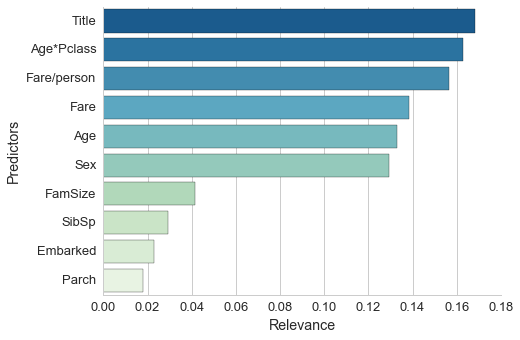

In [419]:
predictors = list(X_train.columns.values)
relevance = list(random_forests.feature_importances_)

# in order to sort them in descending relevance we combine, sort, then split it again into two lists
combined_list = list(zip(predictors, relevance))
sorted_list = sorted(combined_list, key=itemgetter(1), reverse=True)
unzipped = list(zip(*sorted_list))

predictors = list(unzipped[0])
relevance = list(unzipped[1])

# Plotting the predictor relevance
predictor_relevance = pd.DataFrame({
        'Predictors' : predictors,
        'Relevance' : relevance
    })


sns.set(font_scale=1.3)
sns.set_style('whitegrid')
sns.factorplot(x='Relevance', y='Predictors', data=predictor_relevance, palette='GnBu_r', kind='bar', size=5, aspect=1.5)


It is apparent that it was worth it to engineer those features! **Title** is among the most important ones (which is no wonder because it incorporates sex, social status and, to some extent, age), so is **Age\*Pclass** and **Fare/person**.

However, as is pointed out in the description of this challenge, the number of entries in this set is not large at all. That is why, in a single classification step, our fancy model yields a lower prediction accuracy than a simple model involving **Sex** and **Pclass**, for example. In order to predict the survival of the passengers in the test data with a high accuracy, making use of our engineered features, I will have to do some cross-validation! This is going to be the next step of the analysis.

In [386]:
# Creating the submission csv
submission = pd.DataFrame({
        'PassengerId' : test_df['PassengerId'],
        'Survived' : Y_pred_np
    })

submission.to_csv('sinkorsurvive.csv', index=False)

## 6. Summary - so far...

During the course of this notebook I have explored the possible connections between existing and engineered features of the dataset and the survival of the passengers. As a result, we could see some intriguing implications of some of the features on surviving the disaster: gender, social standing, fare per capita and age were among the most important predictors. After munging the data, I used a tree-based model for prediction: the random forest classifier of the sklearn package. However, since the data is relatively small, a single iteration of model building is not enough: one has to do cross-validation between train and test data which will help refine the accuracy of the predicions. This is the next stage in the work coming up soon - so stay tuned!